# Galaxy Zoo - The Galaxy Challenge

In [1]:
# 使うGPUを指定
import os
os.environ["CUDA_VISIBLE_DEVICES"]="9"

# tensorflowは普通に使用すると、GPUメモリを取れるだけとってしまうため、最小限だけ使うように設定する。
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
!echo $CUDA_VISIBLE_DEVICES

9


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('../input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [4]:
from tqdm import tqdm
import zipfile
import io
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras import backend as K

In [6]:
pd.options.display.max_columns = 999
df = pd.read_csv('../input/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.zip')
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [7]:
df.describe()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
count,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000
mean,550179.708337,0.432526,0.542261,0.025213,0.106408,0.435854,0.102526,0.333328,0.215629,0.220224,0.040842,0.180468,0.177904,0.036639,0.231807,0.768193,0.170021,0.207765,0.054740,0.034812,0.013449,0.032807,0.040044,0.064546,0.042307,0.003842,0.063014,0.010614,0.032780,0.091801,0.083969,0.039859,0.015411,0.094338,0.017587,0.007603,0.007006,0.073683
std,258724.130197,0.283517,0.296429,0.037967,0.212505,0.301867,0.177301,0.247675,0.285502,0.179835,0.087419,0.192508,0.180277,0.060300,0.227393,0.227393,0.238860,0.215967,0.110445,0.101319,0.027435,0.051930,0.081152,0.090286,0.108537,0.024408,0.137545,0.038236,0.098200,0.145125,0.139840,0.099657,0.052285,0.193920,0.067476,0.037678,0.037280,0.107454
min,100008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,327874.250000,0.175812,0.280862,0.000000,0.000000,0.168490,0.000000,0.122592,0.000000,0.072656,0.000000,0.000000,0.000000,0.000000,0.066087,0.673057,0.000000,0.032554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,551933.000000,0.416994,0.558754,0.014870,0.000000,0.394850,0.000000,0.289248,0.092987,0.183640,0.000000,0.116580,0.126765,0.000000,0.149545,0.850455,0.035954,0.125757,0.000000,0.000000,0.000000,0.000000,0.000000,0.034163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,773232.000000,0.679182,0.811339,0.034325,0.085161,0.694615,0.134555,0.516800,0.330231,0.338920,0.044376,0.290133,0.284554,0.057294,0.326943,0.933913,0.280679,0.333788,0.049136,0.027767,0.025160,0.046129,0.044907,0.086541,0.032199,0.000000,0.056038,0.000000,0.000000,0.147239,0.127381,0.030621,0.000000,0.098670,0.000000,0.000000,0.000000,0.128798
max,999967.000000,1.000000,1.000000,0.935147,1.000000,1.000000,1.000000,1.000000,1.000000,0.957937,0.803556,0.965112,0.891034,0.650383,1.000000,1.000000,1.000000,1.000000,0.883481,0.969157,0.807733,0.598390,0.860000,0.790470,0.971000,0.719088,0.985982,0.889493,0.901991,0.949733,0.877393,0.996952,0.886363,1.000000,0.975913,0.957000,0.938881,0.753082


In [8]:
# df = df.sample(n=1000, random_state=0)

In [9]:
DATA_DIR = '../input/galaxy-zoo-the-galaxy-challenge/'
zippath = '../input/galaxy-zoo-the-galaxy-challenge/images_training_rev1.zip'
ORIG_SIZE = 424
# IMG_SIZE = 224
IMG_SIZE = 424

# batch_size = 32
batch_size = 16

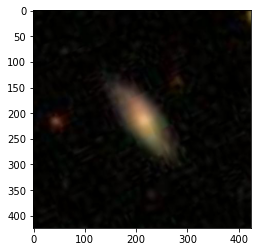

In [10]:
# load zip
zippath = '../input/galaxy-zoo-the-galaxy-challenge/images_training_rev1.zip'
z = zipfile.ZipFile(zippath)

# load image from zip
# imgname = 'images_training_rev1/100008.jpg'
imgname = 'images_training_rev1/100023.jpg'
im = Image.open(io.BytesIO(z.read(imgname)))
im_list = np.asarray(im)
plt.imshow(im_list)
plt.show()

z.close()

In [11]:
im_list.shape

(424, 424, 3)

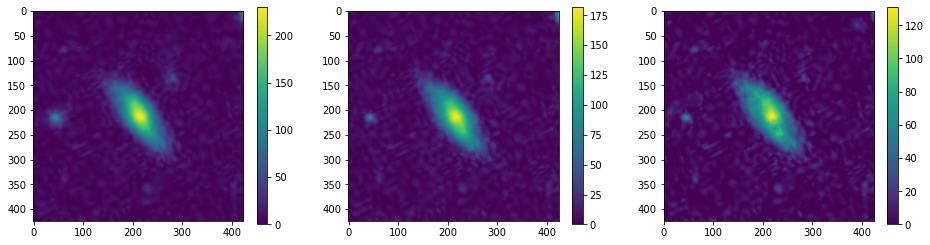

In [12]:
plt.figure(figsize=(16,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(im_list[:,:,i])
    plt.colorbar()
plt.show()

## tf.data.Dataset を使う

In [13]:
def preprocess_image(image, augment_flag=False):
    image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, (IMG_SIZE,IMG_SIZE))
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE, IMG_SIZE)  # 中央crop
    if augment_flag:
        image = tf.image.random_flip_left_right(image)  # 左右反転
        image = tf.image.random_flip_up_down(image)     # 上下反転
    image /= 255  # normalize to [0,1] range

    return image

In [14]:
def load_and_preprocess_image(path):
    img_path = '../input/galaxy-zoo-the-galaxy-challenge/images_training_rev1/' + path + '.jpg'
    image = tf.io.read_file(img_path)
    return preprocess_image(image,  augment_flag=True)

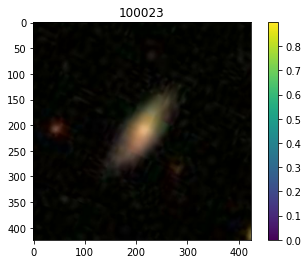

In [15]:
import matplotlib.pyplot as plt

label = str(df.iloc[1, 0])
# label = '303732'
# img_path = '../input/galaxy-zoo-the-galaxy-challenge/images_training_rev1/' + label + '.jpg'

plt.imshow(load_and_preprocess_image(label))
plt.grid(False)
plt.title(label)
plt.colorbar()
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(df.values[:,0].astype(int).astype(str), df.values[:,1:], test_size=0.2, random_state=0)

In [17]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((49262,), (12316,), (49262, 37), (12316, 37))

In [18]:
path_ds = tf.data.Dataset.from_tensor_slices(x_train)

In [19]:
path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [20]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [21]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y_train, tf.float32))

In [22]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [23]:
# ds = image_label_ds.cache(filename='./cache.tf-data')
ds = image_label_ds.cache()
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=1000))
ds = ds.batch(batch_size)

In [24]:
path_ds_valid = tf.data.Dataset.from_tensor_slices(x_test)
image_ds_valid = path_ds_valid.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds_valid = tf.data.Dataset.from_tensor_slices(tf.cast(y_test, tf.float32))
ds_valid = tf.data.Dataset.zip((image_ds_valid, label_ds_valid))
ds_valid = ds_valid.batch(batch_size)

In [25]:
y_test.shape

(12316, 37)

In [26]:
# for x in image_ds:
# for x, y in image_label_ds:
for x, y in ds:
#     print(x.shape)
    print(x.shape, y.shape)
    break

(16, 424, 424, 3) (16, 37)


## Model

In [27]:
# ネットワークの構築
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, MobileNetV2, EfficientNetB0
from tensorflow.keras import models, layers, regularizers

# conv_base = VGG16(weights='imagenet',
# conv_base = ResNet50(weights='imagenet',
# conv_base = ResNet50V2(weights='imagenet',
# conv_base = MobileNetV2(weights='imagenet',
conv_base = EfficientNetB0(weights='imagenet',
                 include_top=False,
                 input_shape=(IMG_SIZE, IMG_SIZE, 3))
# model = keras.models.load_model('tiny-imagenet-200-56-090-0.4291.h5')    ### 学習済みモデルを読み込む場合
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
# model.add(layers.Dense(512, kernel_initializer='he_normal', activation="relu"))
model.add(layers.Dense(37, kernel_initializer='he_normal', activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 14, 14, 1280)      4049571   
_________________________________________________________________
flatten (Flatten)            (None, 250880)            0         
_________________________________________________________________
dense (Dense)                (None, 37)                9282597   
Total params: 13,332,168
Trainable params: 13,290,145
Non-trainable params: 42,023
_________________________________________________________________


In [28]:
conv_base.input_shape

(None, 424, 424, 3)

In [29]:
# for layer in conv_base.layers:
#     print(layer.name)

In [30]:
# 凍結
# conv_base.trainable = False

# 最初から特定の層までを凍結
# conv_base.trainable = True
# set_trainable = False
# for layer in conv_base.layers:
# #     if layer.name == 'block2_conv1':
# #     if layer.name == 'block3_conv1':
#     if layer.name == 'block4_conv1':
# #     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

len(model.trainable_weights)

213

In [31]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [32]:
# オプティマイザ構築
from keras import optimizers

model.compile(loss='MeanSquaredError',
#              optimizer=optimizers.RMSprop(lr=1e-4),
#              optimizer=optimizers.RMSprop(lr=1e-3),
             optimizer=optimizers.Adam(lr=1e-4),
#              optimizer=optimizers.Adam(lr=1e-3),
#              optimizer=optimizers.SGD(lr=0.01),
#              optimizer=optimizers.SGD(lr=0.01, momentum=0.9),
             metrics=['acc', root_mean_squared_error])

In [ ]:
%%time
# history = model.fit(ds, epochs=2, steps_per_epoch=1000//32+1, workers=0, validation_steps=1, validation_data=ds_valid)
# history = model.fit(ds, epochs=2, steps_per_epoch=61578//32+1, workers=0, validation_steps=1, validation_data=ds_valid)
history = model.fit(ds, epochs=5, steps_per_epoch=x_train.shape[0]//batch_size, use_multiprocessing=True, workers=8, validation_steps=1, validation_data=ds_valid)
# history = model.fit(ds, epochs=20, steps_per_epoch=61578//32+1, workers=0, validation_steps=1, validation_data=ds_valid, initial_epoch=2)

Epoch 1/5
3078/3078 [==============================] - 1226s 398ms/step - loss: 0.0248 - acc: 0.6148 - root_mean_squared_error: 0.1561 - val_loss: 0.7799 - val_acc: 0.1250 - val_root_mean_squared_error: 0.8831
Epoch 2/5
3078/3078 [==============================] - 1236s 402ms/step - loss: 0.0182 - acc: 0.6998 - root_mean_squared_error: 0.1344 - val_loss: 0.7582 - val_acc: 0.1250 - val_root_mean_squared_error: 0.8708
Epoch 3/5
3078/3078 [==============================] - 1238s 402ms/step - loss: 0.0161 - acc: 0.7267 - root_mean_squared_error: 0.1264 - val_loss: 0.7002 - val_acc: 0.1250 - val_root_mean_squared_error: 0.8368
Epoch 4/5
2026/3078 [==================>...........] - ETA: 7:02 - loss: 0.0137 - acc: 0.7488 - root_mean_squared_error: 0.1162

In [ ]:
model.save('my_model.h5')

In [ ]:
history.history

In [ ]:
plt.plot(history.history["root_mean_squared_error"], label="train", ls="-", marker="o")
plt.plot(history.history["val_root_mean_squared_error"], label="test", ls="-", marker="x")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

In [ ]:
#acc, val_accのプロット
plt.plot(history.history["acc"], label="train", ls="-", marker="o")
plt.plot(history.history["val_acc"], label="test", ls="-", marker="x")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

## Submission

In [ ]:
submission = pd.read_csv('../input/galaxy-zoo-the-galaxy-challenge/all_ones_benchmark.zip')

In [ ]:
# submission = submission.sample(n=1000, random_state=0)

In [ ]:
submission.shape

In [ ]:
def load_and_preprocess_test_image(path):
    img_path = '../input/galaxy-zoo-the-galaxy-challenge/images_test_rev1/' + path + '.jpg'
    image = tf.io.read_file(img_path)
    return preprocess_image(image)

In [ ]:
import matplotlib.pyplot as plt

label = str(submission.iloc[0, 0])

plt.imshow(load_and_preprocess_test_image(label))
plt.grid(False)
plt.title(label)
print()

In [ ]:
path_ds_test = tf.data.Dataset.from_tensor_slices(submission.values[:,0].astype(int).astype(str))
image_ds_test = path_ds_test.map(load_and_preprocess_test_image, num_parallel_calls=AUTOTUNE)
label_ds_test = tf.data.Dataset.from_tensor_slices(tf.cast(np.zeros((submission.shape[0], 37)), tf.float32))
ds_test = tf.data.Dataset.zip((image_ds_test, label_ds_test))
ds_test = ds_test.batch(batch_size)

In [ ]:
# y_pred = model.predict(test_x)
y_pred = model.predict(ds_test, use_multiprocessing=True, workers=8)

In [ ]:
submission.iloc[:, 1:] = y_pred

In [ ]:
submission.to_csv('../output/submission_dataset.csv', index=False)